<a href="https://colab.research.google.com/github/Springboard-CourseDev/MachineLearningForEngineers/blob/master/Solutions/Build_Project_2_DL_and_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build Project 2: Deep Learning and Regularization

At this point in the curriculum you've been introduced to the basic components of neural networks and how to train them using gradient descent-based algorithms. Note, deep learning and neural networks are used interchangeably here since a neural network with lots of hidden layers is essentially deep learning.   

In this project, you'll be given the opportunity to build and train a neural network to predict click-thru rate (CTR) on a subset of [Kaggle's Avazu CTR dataset](https://www.kaggle.com/competitions/avazu-ctr-prediction/), which you've already been exposed to in the previous build project. The objectives of this project are as follows:

  * Build and train neural networks on the Avazu dataset using Keras.
  * Explore the effect of neural network entities (e.g. batch normalization, class weightings, optimization algorithms) on model performance.  
  * Apply forms of regularization like Dropout, and Early Stopping to reduce over-fitting.  

## Import and Process Data

Import a few libraries you'll be using. Also, set the random seed to get reproducible results. Setting the random seed this way provides deterministic results for Python, NumPy, and TensorFlow. You can read more about this [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed).   

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.keras.utils.set_random_seed(47)

Load the Avazu CTR dataset into pandas.



In [ ]:
avazu_df = pd.read_csv('/content/avazu_ctr.zip')

How many rows and columns are in the raw dataset?

In [ ]:
avazu_df.shape

(404773, 24)

View the first 5 rows in the dataframe. Sometimes, for dataframes with a lot of features, it's useful to transpose the output of the `head` function. 

In [ ]:
avazu_df.head().transpose()

,0,1,2,3,4
id,10004482643316086592,10006777279679619273,10023110164290040687,10060395879435434399,10068417048966587383
click,0,0,0,1,0
hour,14102100,14102100,14102100,14102100,14102100
C1,1005,1005,1005,1005,1005
banner_pos,0,0,0,0,0
site_id,85f751fd,85f751fd,1fbe01fe,d9750ee7,1fbe01fe
site_domain,c4e18dd6,c4e18dd6,f3845767,98572c79,f3845767
site_category,50e219e0,50e219e0,28905ebd,f028772b,28905ebd
app_id,66a5f0f3,d2bb6502,ecad2386,ecad2386,ecad2386
app_domain,d9b5648e,2347f47a,7801e8d9,7801e8d9,7801e8d9


First, check if there are any null values that must be accounted for in the dataset. 

In [ ]:
avazu_df.isnull().any()

id                  False
click               False
hour                False
C1                  False
banner_pos          False
site_id             False
site_domain         False
site_category       False
app_id              False
app_domain          False
app_category        False
device_id           False
device_ip           False
device_model        False
device_type         False
device_conn_type    False
C14                 False
C15                 False
C16                 False
C17                 False
C18                 False
C19                 False
C20                 False
C21                 False
dtype: bool

Let's split the data into training and validation sets.

In [ ]:
X_train, X_test = train_test_split(
    avazu_df, 
    train_size=0.8, 
    random_state=42, 
    shuffle=True
)
y_test = X_test.pop('click')
y_train = X_train.pop('click')

Calculate the ratio of positive labels in the training data.

In [ ]:
y_train.value_counts(normalize=True)

0    0.831578
1    0.168422
Name: click, dtype: float64

Calculate the ratio of positive labels in the test data. We expect this to be similar to the training data. This is a slightly unbalanced dataset.

In [ ]:
y_test.value_counts(normalize=True)

0    0.831388
1    0.168612
Name: click, dtype: float64

From the `hour` feature, extract the actual hour of day from the provided string. Do this for both the train and test data. 

In [ ]:
X_train['hour'] = X_train['hour'].apply(lambda x: str(x)[-2:])
X_test['hour'] = X_test['hour'].apply(lambda x: str(x)[-2:])

From the previous project that focused on EDA for the Avazu dataset, we know most of the features are categorical. The following dictionary is keyed by feature name for which one hot encoding will be applied. Values are category values to binarize. This object will be used as input to a Scikit-Learn `Pipeline`. Features not keyed in the dictionary will be removed altogether. 

In [ ]:
cols_ohe = {
    'hour': np.sort(X_train['hour'].unique()),
    'C1': [1002, 1005, 1010],
    'banner_pos': [0, 1],
    'site_id': ['85f751fd', '1fbe01fe', 'e151e245', 'd9750ee7', '5b08c53b'],
    'site_domain': ['c4e18dd6', 'f3845767', '7e091613', '7687a86e', '98572c79'],
    'site_category': ['50e219e0', 'f028772b', '28905ebd', '3e814130'],
    'app_id': ['ecad2386'],
    'app_domain': ['7801e8d9', '2347f47a'],
    'app_category': ['07d7df22', '0f2161f8'],
    'device_id': ['a99f214a'],
    'device_conn_type': [0, 2, 3, 5],
    'C15': [300, 320],
    'C18': [0, 1, 2, 3],
    'C19': [35, 39, 167],
    'C20': [-1],
    'C21': [23, 48, 61, 71, 79, 221],
}

Import relevant Scikit-Learn Pipeline libraries needed to apply columns transformations. 

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

**Exercise**: Create a `Pipeline` object that applies One Hot Encoding to the columns defined in the `cols_ohe` dictionary. Apply the pipeline to the train and test data, savings the results for later use. 

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe',
         OneHotEncoder(
             categories=list(cols_ohe.values()),
             handle_unknown='ignore',
             sparse=False
         ),
         list(cols_ohe.keys())
         )
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocessor', preprocessor)
    ]
)

In [ ]:
Xt_train = pipe.fit_transform(X_train)
Xt_test = pipe.fit_transform(X_test)

In [ ]:
Xt_train.shape, Xt_test.shape

((323818, 69), (80955, 69))

## Build a Baseline

As discussed in a previous project, it's always crucial to start off a machine learning project by building a solid baseline model. The baseline model should be quick to build while still yielding non-trivial performance. Here and throughout the rest of this project, use the [area under the receiver operating curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) metric to gauge model performance.

**Exercise**: Build a baseline model using `RandomForestClassifier`. Evaluate the model on the test data using the `roc_auc_score` function. How does the baseline model perform compared to a model that outputs random labels? 

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier()
rf.fit(Xt_train, y_train)
y_pred = rf.predict_proba(Xt_test)

In [ ]:
roc_auc_score(y_test, y_pred[:, 1])

0.6785867799337824

## First Neural Network

When building a neural network, it's good practice to start simple and slowly add layers of comlexity to gain model improvement. In this section we reproduce a logistic regression model (no hidden layers) using Keras. In the proceeding sections, we'll build on this network. Note, we opt to use Keras' Functional API instead of the Sequential API. Both work here but the Functional API is more versataille. A great discussion comparing these two can be found [here]( https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/). 

First, import some Keras features we'll be using.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense 

**Exercise**: Use the Keras imports from above to define a `Model` object that reproduces logistic regression. Compile the model using the [Adam](https://keras.io/api/optimizers/adam/) optimizer and a [Binary Cross-Entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss function. How many trainable parameters does the model have?

In [ ]:
input_layer = Input(shape=(Xt_train.shape[-1], ))
output_layer= Dense(1, activation='sigmoid')(input_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 69)]              0         
                                                                 
 dense (Dense)               (None, 1)                 70        
                                                                 
Total params: 70
Trainable params: 70
Non-trainable params: 0
_________________________________________________________________


**Exercise**: Fit the model to the training data and calculate the `roc_auc_score` score on the test data. Does the model out perform the baseline? If the model trains slowly, play around with the batch size. The smaller the batch size the more frequently gradient updates occur. Also, play around with the `epochs`, or how many times the model goes through the entire training set. How does changing `epoochs` affect model performance? 

In [ ]:
model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=10000, 
    validation_data=(Xt_test, y_test),
    verbose=0
);

In [ ]:
y_pred = model.predict(Xt_test)
roc_auc_score(y_test, y_pred)

0.6582723281720384

## Add Complexity

With a basic neural network built, it's time to build in some hidden layers. Hidden layers enable the neural network to learn non-linear features, which is what makes them so powerful.  

**Exercise**: Build a neural network with three hidden dense layers, each of length 256 and activated with a rectified linear unit. Compile the model with an `adam` optimizer and `binary_crossentropy` loss. Also, for each epoch trained, have the AUC metric calculated. How many trainable parameters does the model have? 

In [ ]:
input_layer = Input(shape=(Xt_train.shape[-1], ))
x = Dense(256, activation='relu')(input_layer)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

metrics = [tf.keras.metrics.AUC(name='auc')]

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=metrics
)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 69)]              0         
                                                                 
 dense_8 (Dense)             (None, 256)               17920     
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 149,761
Trainable params: 149,761
Non-trainable params: 0
_________________________________________________________________


**Exercise**: Fit the model and make sure to the the output to a variable, which contains the training history. Plot the validation and training loss values as a function of epoch. Also, plot the validation and training auc scores as a function of epoch. Is there a clear point where the model starts to overfit the training data?

In [ ]:
history = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=10000, 
    validation_data=(Xt_test, y_test),
    verbose=0
)

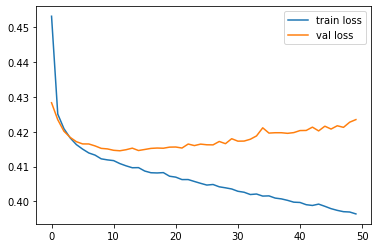

In [ ]:
sns.lineplot(
    x=range(history.params['epochs']),
    y=history.history['loss'],
    label='train loss'
);
sns.lineplot(
    x=range(history.params['epochs']),
    y=history.history['val_loss'],
    label='val loss'
);          

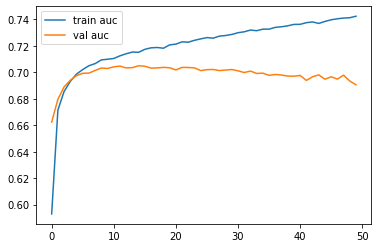

In [ ]:
sns.lineplot(
    x=range(history.params['epochs']),
    y=history.history['auc'],
    label='train auc'
);
sns.lineplot(
    x=range(history.params['epochs']),
    y=history.history['val_auc'],
    label='val auc'
);          

**Exercise**: Write a function that accepts the training and test data and calculates the `roc_auc_score` on each using the last saved weights of the model.   

In [ ]:
def evaluate_model(model, X_test, y_test, X_train, y_train):
  """Calculates model auc score on train and test sets.

    Inputs:
      model (Keras model): Compiled and fitted model.
      X_test (pandas df): Features in the test data.
      y_test (array): True labels in the test data.
      X_train (pandas df): Features in the train data.
      y_train (array): True labels in the train data.
    
    Returns:
      None -- Prints AUC score for train and test data.
  """
  y_pred = model.predict(X_test)
  print('Test AUC score: {0:4.3f}'.format(roc_auc_score(y_test, y_pred)))
  y_pred = model.predict(X_train)
  print('Train AUC score: {0:4.3f}'.format(roc_auc_score(y_train, y_pred)))

In [ ]:
evaluate_model(model, Xt_test, y_test, Xt_train, y_train)

Test AUC score: 0.691
Train AUC score: 0.748


## Regularization

In the previous section, you should have noticed that at some point during training the validation and train losses began to diverge. At this point, the model began to overfit the data. Neural networks have a tendency to overfit data simply due to the fact that they have so many free parameters. Fortunately, there are many options to apply regularization to neural networks. Some of these options will be explored in this section.

### Early Stopping

When plotting the validation and training losses you should have seen the two diverge at some point, where the model starts to overfit the training data. One intuitive way of stopping this overfitting is to simply end model training. This approach is called "Early Stopping" and can be very effective.  

![](https://miro.medium.com/max/1134/1*2BvEinjHM4SXt2ge0MOi4w.png)[Source](https://medium.com/@rahuljain13101999/why-early-stopping-works-as-regularization-b9f0a6c2772)

Import a few modules we'll be using for regularization.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

**Exercise**: For the model defined in this section, apply Early Stopping while monitoring the AUC score on the validation set. Make sure you read the [documentation](https://keras.io/api/callbacks/early_stopping/) carefully to make sure the default values for `EarlyStopping` are the ones you want. Use the `evaluate_model` function written earlier to get the AUC metric on the training data. Did the model outperform the model that didn't use Early Stopping? After how many epochs did the model stop training?

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_auc', 
        patience=5, 
        restore_best_weights=True
    )
]

history = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=10000, 
    validation_data=(Xt_test, y_test),
    verbose=0,
    callbacks=callbacks
)

In [ ]:
evaluate_model(model, Xt_test, y_test, Xt_train, y_train)

Test AUC score: 0.694
Train AUC score: 0.747


### Dropout

Dropout is another form of regularization that has been found to be extremely effective in deep learning. The basic idea behind dropout is to randomly inactivate a subset of nodes in a layer with each training pass. Nodes are therefore forced to learn more robust features rather than specifics of the training data. 

![](https://miro.medium.com/max/1400/1*iWQzxhVlvadk6VAJjsgXgg.png) [Source](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)

**Exercise**: Leveraging the same model architecture with the three hidden layers, add a [dropout layer](https://keras.io/api/layers/regularization_layers/dropout/) after each dense hidden layer. Remember to recompile the model and then train it. Play around with the percentage of nodes to dropouut. Use the `evaluate_model` function to get AUC scores on the test set. 

In [ ]:
input_layer = Input(shape=(Xt_train.shape[-1], ))
x = Dense(256, activation='relu')(input_layer)
x = Dropout(.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
output_layer= Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=metrics
)

history = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=10000, 
    validation_data=(Xt_test, y_test),
    verbose=0
)

In [ ]:
evaluate_model(model, Xt_test, y_test, Xt_train, y_train)

Test AUC score: 0.704
Train AUC score: 0.731


## Experiment 

The best way to get good at applying neural networks is to experiment. In this section, see if you can beat previous performance metrics by trying some of the following ideas:

  * Try different [optimizers](https://keras.io/api/optimizers/), including using a non-default learning rate
  * Make the network deeper
  * Different [activation functions](https://keras.io/api/layers/activations/)
  * [Batch normalization with dropout](https://machinelearningmastery.com/batch-normalization-for-training-of-deep-neural-networks/#:~:text=Batch%20normalization%20offers%20some%20regularization,up%20training%2C%20without%20increasing%20overfitting)
  * Different batch sizes
  * Apply weightings to adjust for imbalanced dataset
  * Set the [correct initial bias for an imbalanced dataset](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#optional_set_the_correct_initial_bias)

**Exercise**: Using the architecture used previously with the dropout layers, add [Batch Normalization](https://keras.io/api/layers/normalization_layers/batch_normalization/) before applying dropout and fit the new model. Evaluate the model and compare to previous performance. 

In [ ]:
input_layer = Input(shape=(Xt_train.shape[-1], ))
x = BatchNormalization()(input_layer)
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.2)(x)
x = BatchNormalization()(x)
output_layer= Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=metrics
)

In [ ]:
history = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=10000, 
    validation_data=(Xt_test, y_test),
    verbose=0,
    callbacks=callbacks
)

In [ ]:
evaluate_model(model, Xt_test, y_test, Xt_train, y_train)

Test AUC score: 0.696
Train AUC score: 0.728


**Exercise**: Leverage the model just built to gauge the effect of batch size on model performance. For each of the batch sizes 512, 1024, 2048, 4096, 8192, 16384, and 32768, train the model with early stopping and calculate the AUC score on the test set. Make a plot of batch size against model performance. What's the optimal batch size? You might want to get a cup of coffee for this one. 

In [ ]:
batch_sizes = [512, 1024, 2048, 4096, 8192, 16384, 32768]
auc_scores = []
for batch_size in batch_sizes:
  print('Working on batch size = {0}...'.format(batch_size))
  _ = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=batch_size, 
    validation_data=(Xt_test, y_test),
    verbose=0,
    callbacks=callbacks
  )
  y_pred = model.predict(Xt_test)
  auc_scores.append(roc_auc_score(y_test, y_pred))

Working on batch size = 512...
Working on batch size = 1024...
Working on batch size = 2048...
Working on batch size = 4096...
Working on batch size = 8192...
Working on batch size = 16384...
Working on batch size = 32768...


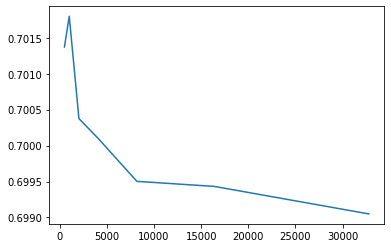

In [ ]:
sns.lineplot(x=batch_sizes, y=auc_scores);

**Exercise**: While the Avazu dataset is not terribly imbalanced, it is far skewed from a 50/50 split of labels. Read [Keras' documentation](https://keras.io/examples/structured_data/imbalanced_classification/) for dealing with imbalanced datasets and apply the `class_weight` parameter during model fitting. Evaluate the model. Does performance increase?  

In [ ]:
counts = np.bincount(y_train)
class_weight = {0: 1./counts[0], 1: 1./counts[1]}
class_weight

{0: 3.7136066547831253e-06, 1: 1.833583923136162e-05}

In [ ]:
history = model.fit(
    Xt_train, y_train, 
    epochs=50, 
    batch_size=1024, 
    validation_data=(Xt_test, y_test),
    verbose=0,
    callbacks=callbacks,
    class_weight=class_weight
  )

In [ ]:
evaluate_model(model, Xt_test, y_test, Xt_train, y_train)

Test AUC score: 0.701
Train AUC score: 0.733


**Exercise**: Try something new to get the most performant model yet.